# We substitute all non ACTG with * and - is for padding 

# filter: only regions with genome counts>=threshold will be considered

# Sample: sample n_sample from each region

# Preprocessing: filter -> Sample -> padded -> encode -> leave one out


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from utility_functions import *
from functions import *



2024-02-19 13:01:32.111717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 13:01:32.677689: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /shared/centos7/anaconda3/2022.05/lib:/shared/centos7/nodejs/14.15.4/lib
2024-02-19 13:01:32.677727: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-19 13:01:37.158225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Memory Total (GB):", torch.cuda.get_device_properties(0).total_memory / 1e9)
    print("GPU Memory Allocated (GB):", torch.cuda.memory_allocated(0) / 1e9)
    print("GPU Memory Cached (GB):", torch.cuda.memory_reserved(0) / 1e9)
else:
    print("GPU is not available.")

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


GPU is not available.
2.2.0+cu121
12.1
False


In [3]:
x = torch.rand(5, 3)
print(x)

tensor([[0.1252, 0.9456, 0.5686],
        [0.7642, 0.2864, 0.1199],
        [0.8550, 0.5942, 0.3560],
        [0.7684, 0.7136, 0.3894],
        [0.1497, 0.0959, 0.2232]])


In [4]:
def filter_Nbase(row):
    if len(set(row['sequence'])) <=10:
        return False
    else:
        return True



In [5]:
df_date=pd.read_csv('data/df_date.csv')  



In [6]:
def replace_byN(sequence):
    # replace all non-ATCG by N
    return re.sub('[^ATCG]', '*', sequence) 

    

In [7]:
df_date_replace_nonATCG_byN=df_date

In [8]:
df_date_replace_nonATCG_byN['sequence']=df_date_replace_nonATCG_byN['sequence'].apply(replace_byN)

In [9]:
df_date_replace_nonATCG_byN

,sequence,region,strain,year,source,Date,Month,country
0,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Italy,LOM-UniMI-1,2020,-,2019-12-05,1,Italy
1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Wuhan,IPBCAMS-WH-01,2019,-,2019-12-24,1,China
2,AACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAAC...,Wuhan,WH01,2019,-,2019-12-26,1,China
3,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...,Wuhan,IPBCAMS-WH-04,2019,-,2019-12-30,1,China
4,CCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCT...,Wuhan,HBCDC-HB-04,2020,-,2019-12-30,1,China
...,...,...,...,...,...,...,...,...
551225,ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...,DRC,10057,2020,-,2021-05-14,18,Dominican Republic
551226,AACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAAT...,DRC,10364,2020,-,2021-05-17,18,Dominican Republic
551227,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCT...,DRC,10733,2020,-,2021-05-17,18,Dominican Republic
551228,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCT...,DRC,10902,2020,-,2021-05-18,18,Dominican Republic


In [10]:
set(df_date_replace_nonATCG_byN['sequence'][100])

{'*', 'A', 'C', 'G', 'T'}

In [11]:
# evenly select sample_size number of genome sequences from each region
threshold=1000  
sample_size=1000 

df_filtered=filter_df(df_date_replace_nonATCG_byN,'region', threshold)
df_even_=df_filtered.groupby("region").apply (lambda x: x.sample(n=sample_size,random_state=1))
df_even=df_even_.reset_index(drop=True)
print(len(list(set(df_even['region']))))

33


In [12]:
def padding(df,padded_len=None):
    
    df=df.copy()

    #Getting all the base elements
    sequences = df['sequence'].tolist()
    bases = set(x for sublist in sequences for x in sublist)

    #find the max len of the sequences
    max_len=np.max([len(i) for i in df['sequence']])  #initialisation

    if padded_len==None:
        padded_len=max_len

    #Padd the sequences with '-' to ensure the same length
    df['sequence']=df['sequence'].str.pad(width=padded_len, side='right', fillchar='-')
    df['sequence'] = df['sequence']
    bases=bases.copy()
    bases.add('-')
    return df,bases   


In [13]:
df_padded,bases=padding(df_even)

In [14]:
bases

{'*', '-', 'A', 'C', 'G', 'T'}

In [19]:
[(i,len(j)) for i,j in enumerate(list(df_padded['sequence'])) if len(j)!=len(list(df_padded['sequence'][0]))]

[]

In [20]:
df_even

,sequence,region,strain,year,source,Date,Month,country
0,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...,Australia,NSW62,2020,-,2020-03-17,4,Australia
1,CTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCT...,Australia,VIC2179,2020,-,2020-06-26,7,Australia
2,ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...,Australia,VIC14076,2020,-,2020-09-17,10,Australia
3,CTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACT...,Australia,VIC17608,2020,-,2020-08-22,9,Australia
4,ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...,Australia,VIC1557,2020,-,2020-05-02,6,Australia
...,...,...,...,...,...,...,...,...
32995,ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...,Wales,PHWC-48E419,2020,-,2020-11-12,12,United Kingdom
32996,ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...,Wales,PHWC-49CC6B,2020,-,2020-12-08,13,United Kingdom
32997,AGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTC...,Wales,ALDP-AA4981,2020,-,2020-10-21,11,United Kingdom
32998,ACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATC...,Wales,PHWC-24C99,2020,-,2020-03-21,4,United Kingdom


In [20]:
months=sorted(list(set([i[:7] for i in list(df_date['Date'])])))
start,end=7,len(months)-1
start_month=months[start]
print('start_month',start_month)
end_month=months[end]
print('end_month',end_month)
df_date=df_date[df_date['Month']>=start]
print(start)


start_month 2020-07
end_month 2021-05
7


In [21]:
df_padded.to_csv(f'data/genomeACTGbases_sample_{threshold}_{sample_size}_{start_month}---{end_month}.csv', index=False)


In [19]:
bases

{'*', '-', 'A', 'C', 'G', 'T'}

In [21]:
print(len(list(set(list(df_date['region'])))))
print(list(set(list(df_date['region']))))

152
['Greece', 'Guatemala', 'Lebanon', 'Mali', 'Shulan', 'SaintLucia', 'Ireland', 'Lithuania', 'Gibraltar', 'Trinidad', 'Nepal', 'NewZealand', 'Urumqi', 'Bulgaria', 'Beijing', 'Qingdao', 'BritishVirginIslands', 'Japan', 'Sweden', 'NorthernIreland', 'Vietnam', 'FrenchGuiana', 'DRC', 'Bahrain', 'Mongolia', 'Croatia', 'Senegal', 'Congo', 'Italy', 'Georgia', 'Ghana', 'England', 'Chile', 'Mayotte', 'Zimbabwe', 'Fujian', 'CaymanIslands', 'Iran', 'Netherlands', 'Moldova', 'Iraq', 'Hebei', 'Afghanistan', 'Austria', 'Finland', 'Malaysia', 'Curacao', 'Brunei', 'Cambodia', 'Algeria', 'Latvia', 'Shaoxing', 'UnitedArabEmirates', 'BurkinaFaso', 'Tunisia', 'SriLanka', 'Colombia', 'Mozambique', 'Spain', 'Denmark', 'Zambia', 'SouthAfrica', 'Portugal', 'Guadeloupe', 'Poland', 'Canada', 'Guangdong', 'Suriname', 'Scotland', 'Ukraine', 'Taiwan', 'Kashgar', 'Bermuda', 'PapuaNewGuinea', 'StEustatius', 'France', 'India', 'Liaoning', 'Norway', 'DominicanRepublic', 'Singapore', 'Slovenia', 'Wales', 'Crimea', 'U

In [22]:
# evenly select sample_size number of genome sequences from each region
from utility_functions import *

from functions import *
threshold=10000  
sample_size=10000 

df_filtered=filter_df(df_date,'region', threshold)
df_even_=df_filtered.groupby("region").apply (lambda x: x.sample(n=sample_size,random_state=1))
df_even=df_even_.reset_index(drop=True)
len(list(set(df_even['region'])))



8

5


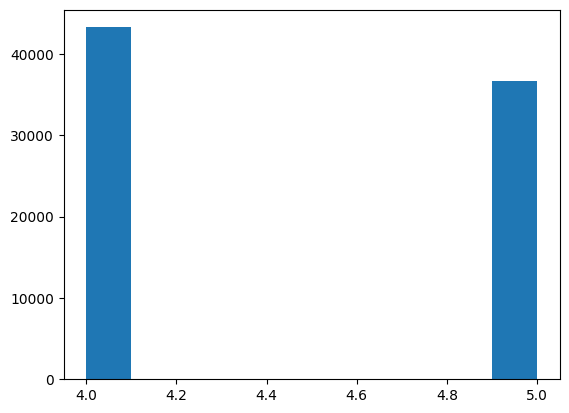

In [23]:
sequences = df_even['sequence'].tolist()


n_base_per_seq=[]
n_base_per_seq=[len(set(seq)) for seq in sequences]
plt.hist(n_base_per_seq)

print(max(n_base_per_seq))

In [ ]:
data=df_even
target='region'
print('2^15',2**15)

#data_padded,base=padding(data,2**15) 
data_padded,base=padding(data) #default pad to max length



In [ ]:
result_dict=defaultdict()

X_train,y_train,X_test,y_test,X_validation,y_validation,\
one_hot_encoder_y=padded_encode(data_padded,target,base,train_size_=0.6,test_size_=0.2,split=True)

n_class=len(list(set(list(data_padded['region']))))
